In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from agentic_energy.schemas import BatteryParams, DayInputs, SolveRequest
from agentic_energy.reinforcementlearning.trainer import train_rllib
from agentic_energy.reinforcementlearning.evaluator import rollout_day
from agentic_energy.reinforcementlearning.config import PPOTrainSettings

Currently, RLlib incompatible with Agentics, I cannot load the dataloaders, so directly using the schemas, for battery, and use pandas to load csv files.

In [2]:
actual_data = pd.read_csv("agentic_energy/data/Italy_data_actual.csv")
forecast_data = pd.read_csv("agentic_energy/data/Italy_data_forecast_RF.csv")

In [3]:
actual_data.shape, forecast_data.shape[0]//24 - 1

((17518, 3), 728)

In [4]:
stats=forecast_data.describe()
p25, p75 = stats.loc['25%','consumption'], stats.loc['75%','consumption']
p25,p75

(np.float64(27.705959175), np.float64(38.2922519125))

In [5]:
# iqr_range_kw = p75 - p25
# capacity_kwh = iqr_range_kw * 4
# cmax_kw = capacity_kwh / 4
# dmax_kw = cmax_kw

battery=BatteryParams(
    capacity_kwh=49.44,
    cmax_kw=12.36,
    dmax_kw=12.36,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c=0.95,
    eta_d=0.95,
    soc_target=0.5,
)
battery

BatteryParams(capacity_kwh=49.44, soc_init=0.5, soc_min=0.0, soc_max=1.0, cmax_kw=12.36, dmax_kw=12.36, eta_c=0.95, eta_d=0.95, soc_target=0.5)

In [6]:
rng = np.random.default_rng(0)
days = []
for i in range(len(forecast_data)//24):

    forecast_prices, forecast_demand = forecast_data["prices"][i*24:(i+1)*24].values, forecast_data["consumption"][i*24:(i+1)*24].values
    actual_prices, actual_demand = actual_data["prices"][i*24:(i+1)*24].values, actual_data["consumption"][i*24:(i+1)*24].values

    days.append(DayInputs(
        prices_buy=actual_prices.tolist(),
        demand_kw=actual_demand.tolist(),
        prices_sell=actual_prices.tolist(),
        allow_export=False,
        dt_hours=1.0,
        prices_buy_forecast=forecast_prices.tolist(),
        demand_kw_forecast=forecast_demand.tolist(),
        prices_sell_forecast=forecast_prices.tolist(),
    ))

train_days = days[:-1]
test_day = days[-1]


eval_req = SolveRequest(battery=battery, day=test_day, solver="RL", solver_opts={"lambda_smooth": 0.00})


In [7]:
settings = PPOTrainSettings(
    num_env_runners=4, # working on 4 cores, 4 cores left for otherd
    rollout_fragment_length=24, # 1 full day per episode
    gamma=0.99, 
    lr=3e-4,
    train_batch_size=24*128,
    minibatch_size=24*4,
    num_epochs=10,                 # bump to 10 if stable
    clip_param=0.2,
    vf_clip_param=10.0,
    evaluation_interval=5,
    evaluation_episodes=10,
)

ckpt = train_rllib(
    eval_req, days,
    settings = settings,
    num_iterations=150,
    obs_mode="forecast", obs_window=24
)

:job_id:01000000
:actor_name:RolloutWorker


:job_id:01000000
:actor_name:RolloutWorker


:actor_name:RolloutWorker
:actor_name:RolloutWorker


:actor_name:RolloutWorker
:actor_name:RolloutWorker


:actor_name:RolloutWorker


:actor_name:RolloutWorker
2025-10-16 22:19:20,215	WARNING util.py:61 -- Install gputil for GPU system monitoring.


TensorBoard logdir: runs/rllib_battery/PPO_battery_Italy
[TRAIN] ep#   25  R= -18.974 len=24
[TRAIN] ep#   25  R= -26.014 len=24
[TRAIN] ep#   25  R= -25.030 len=24
[TRAIN] ep#   25  R= -24.080 len=24
[ITER   1] trainR=-21.72 (EMA=-21.72)  evalR=NA  KL=0.003⚠  Entropy=1.411  Vexp=0.076⚠
        notes: KL low → higher lr or more epochs | Value net weak → adjust value loss coeff or lr
[TRAIN] ep#   50  R= -25.292 len=24
[TRAIN] ep#   50  R= -28.184 len=24
[TRAIN] ep#   50  R= -15.979 len=24
[TRAIN] ep#   50  R= -25.009 len=24
[ITER   2] trainR=-22.36 (EMA=-21.79)  evalR=NA  KL=0.010✅  Entropy=1.432  Vexp=0.737⚠
[TRAIN] ep#   75  R= -19.286 len=24
[TRAIN] ep#   75  R= -24.597 len=24
[TRAIN] ep#   75  R= -25.393 len=24
[TRAIN] ep#   75  R= -18.752 len=24
[ITER   3] trainR=-21.68 (EMA=-21.78)  evalR=NA  KL=0.006✅  Entropy=1.542  Vexp=0.890✅
[TRAIN] ep#  100  R= -29.964 len=24
[TRAIN] ep#  100  R= -24.936 len=24
[TRAIN] ep#  100  R= -20.589 len=24
[TRAIN] ep#  100  R= -26.299 len=24
[TRAIN] 

In [8]:
ckpt

PosixPath('runs/rllib_battery')

In [24]:
eval_req = SolveRequest(battery=battery, day=train_days[0], solver="RL", solver_opts={"lambda_smooth": 0.00})
res = rollout_day(ckpt, eval_req, obs_mode="forecast", obs_window=24)
res


2025-10-16 22:26:58,108	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Rollout done. Episode return (scaled): -18.487 | Cost: 25691.096


SolveResponse(status='rllib_policy', message=None, objective_cost=25691.095703125, charge_kw=[4.463018894195557, 4.157176494598389, 3.8818843364715576, 3.295236587524414, 2.455813407897949, 1.387285828590393, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], discharge_kw=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0698956847190857, 1.5288865566253662, 3.347135066986084, 7.211031913757324, 11.50189208984375, 12.359999656677246, 5.190634250640869, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11, 1.2363443602225743e-11], import_kw=[27.443017959594727, 25.96717643737793, 24.641883850097656, 23.265235900878906, 21.945812225341797, 21.227285385131836, 21.030105590820312, 20.57111358642578, 19.05286407470703, 16.37896728515625, 12.868108749389648, 12.59999942779541, 19.869365

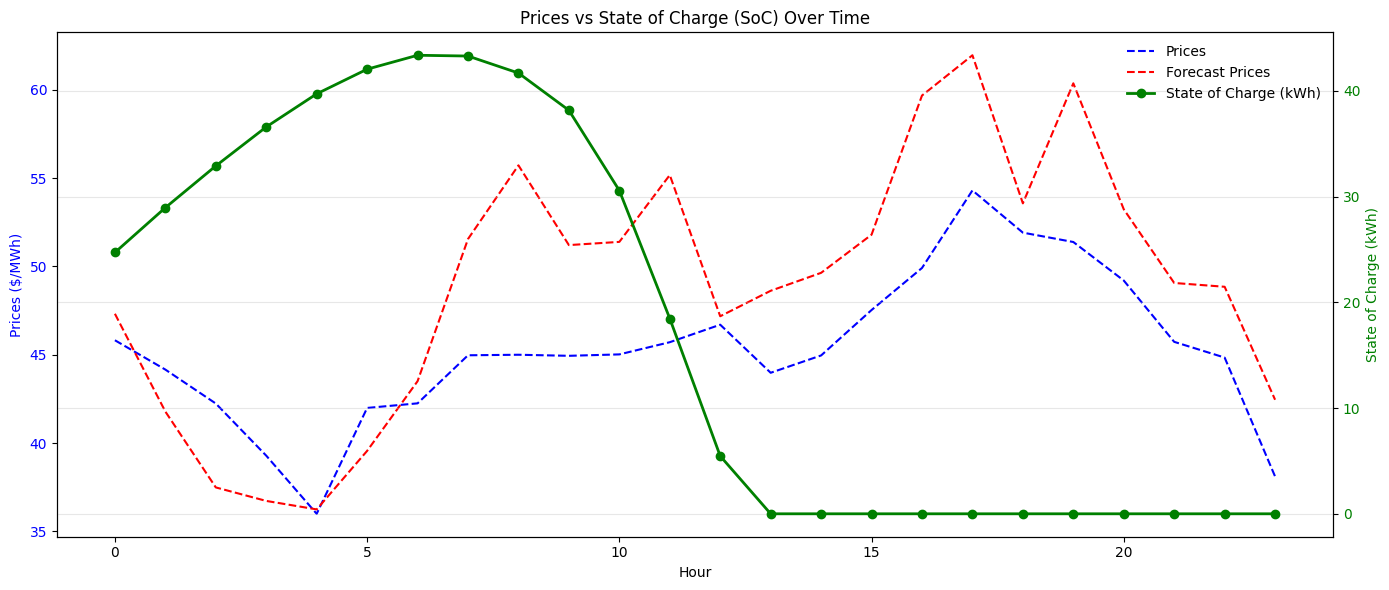

In [25]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, eval_req.day.prices_buy, '--b', label='Prices')
ax1.plot(hours, eval_req.day.prices_buy_forecast, '--r', label='Forecast Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(res.soc[:-1]) * battery.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


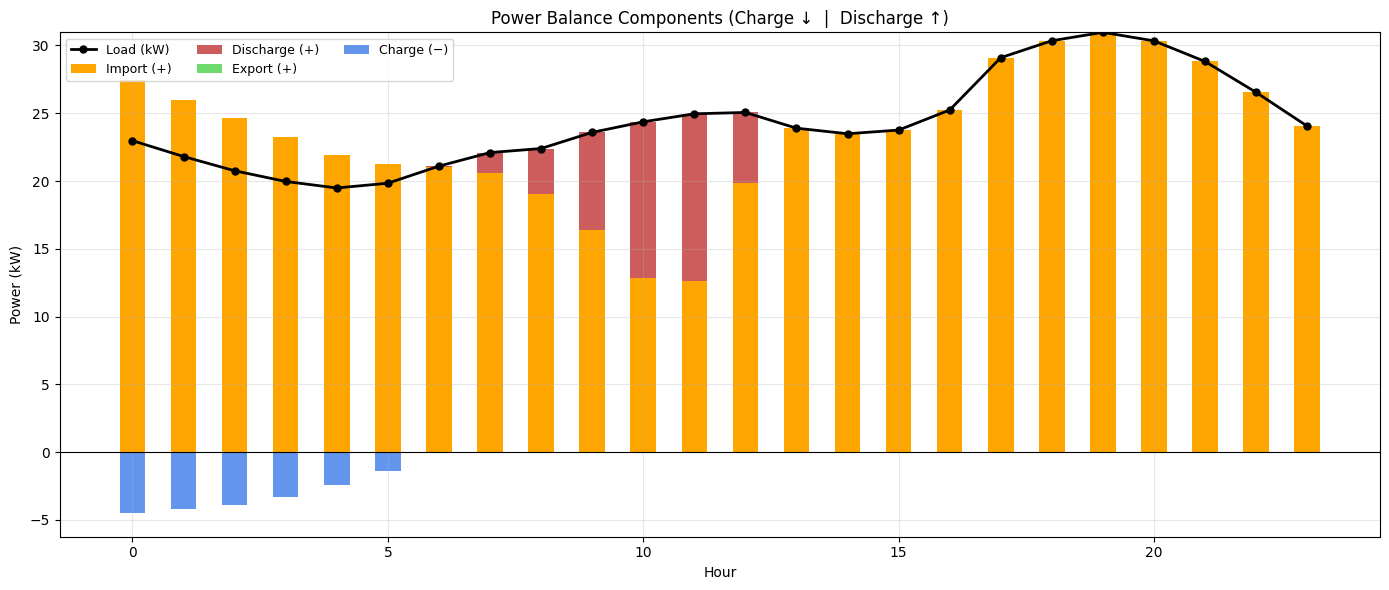

In [26]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(eval_req.day.demand_kw)
charge = np.array(res.charge_kw)
discharge = np.array(res.discharge_kw)
import_kw = np.array(res.import_kw)
export_kw = np.array(res.export_kw) if getattr(eval_req.day, "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
total_objective_value = 0
for day_result in [res]:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len([res])} days")

Total Objective Value over all days: $25691.10 for 1 days


In [28]:
from typing import Sequence, Optional
def cost_from_soc(
    soc: Sequence[float],
    prices_buy: Sequence[float],
    demand_kw: Sequence[float],
    *,
    battery: BatteryParams,
    prices_sell: Optional[Sequence[float]] = None,
    allow_export: bool = False,
    dt_hours: float = 1.0,
):
    soc = np.asarray(soc, dtype=float)
    assert len(soc) >= 2, "SOC must include at least t=0 and t=1"
    T = len(soc) - 1

    prices_buy  = np.asarray(prices_buy, dtype=float)
    demand_kw   = np.asarray(demand_kw, dtype=float)
    assert len(prices_buy) == T and len(demand_kw) == T

    if prices_sell is None:
        prices_sell = prices_buy
    prices_sell = np.asarray(prices_sell, dtype=float)
    assert len(prices_sell) == T

    # Per-step energy change in kWh
    dE = (soc[1:] - soc[:-1]) * battery.capacity_kwh

    # Recover charge/discharge kW from SOC deltas and efficiencies
    charge_kw    = np.maximum(dE, 0.0) / (battery.eta_c * dt_hours)
    discharge_kw = np.maximum(-dE, 0.0) * (battery.eta_d / dt_hours)

    # Enforce hardware limits
    charge_kw    = np.minimum(charge_kw,    battery.cmax_kw)
    discharge_kw = np.minimum(discharge_kw, battery.dmax_kw)

    # Grid net load
    net = demand_kw + charge_kw - discharge_kw
    imp = np.maximum(net, 0.0)
    exp = np.maximum(-net, 0.0) if allow_export else np.zeros_like(net)

    # Cost (buy imports, optionally credit exports)
    cost = float(np.sum(prices_buy * imp * dt_hours) - np.sum(prices_sell * exp * dt_hours))

    out = {
        "charge_kw": charge_kw,
        "discharge_kw": discharge_kw,
        "import_kw": imp,
        "export_kw": exp,
        "net_kw": net,
        "objective_cost": cost,
    }
    return out

out = cost_from_soc(
    soc = res.soc,
    prices_buy=eval_req.day.prices_buy,
    demand_kw=eval_req.day.demand_kw,
    battery=battery,
    prices_sell=eval_req.day.prices_sell,
    allow_export=True,
    dt_hours=1
)
out["objective_cost"]

25691.095635278973

In [29]:
out["discharge_kw"]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.06989539,  1.52888852,  3.34713449,  7.21103071,
       11.50189294, 12.35999974,  5.19063415,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])